# Constraining Shape Systematics

**Motivation:** I proposed choosing the correct pairing using the min $\Delta R_{jj}^{HC1}$, and I liked it because it reduced the backround in the SR and (visually) looked like a smoother background distribution in the massplane.
We thought that a smoother massplane would mean that the SB->CR extrapolation would have a smaller background systematic.

However, when I calculated this in the `min-dRjj1-comparisons` notebook, the expeted upper limit on $\mu$ was *50% higher*.
Rafael thought this was because we preferentailly lost background events at low $m_{4j}$, wich makes it harder to constrain the background normalization, so I can test this hypothesis by looking at the *baseline* analysis, but only looking at $m_{4j}$ above 400 GeV, to see if this less constrained background gives us a similarly worse limit on the expected $\mu$.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import uproot
import pickle
import json

import os
os.sys.path.append('../../hh4b-background-estimation/hep_ml')
from hep_ml import reweight

os.sys.path.append('../code')
from plotting import sig_bkg_massplanes, bkg_2bsameHC_massplanes, bkg_2b_rw_massplanes
from plotting import cf_1d_dists, plot_results, invert_interval
from plotting import SR_x,SR_y1,SR_y2,CR_x,CR_y1,CR_y2,SB_x,SB_y1,SB_y2

from AnalysisUtils import *

import pyhf 
from pyhf import Model, optimizer

%load_ext autoreload
%autoreload 2

Running w/ conda env: don't import root packages.


## Step 1: Load in the data and the reweighting BDTs

**Note:** I can probably speed up this nb by just loading in a part of the full dataframe.

**Question:** Do I have the same number of events if I look at Sean's files instead of the 2016 data samples I made just running over the 2016 XhhCommon files myself with the 2016 triggers?

In [3]:
fileName = "../../hh4b-resolved-reconstruction/{}_topo_2016triggers.root"

In [4]:
smnr = nanoToDf(fileName.format("smnr"),ttree='fullmassplane')

fullmassplane


In [5]:
myData = nanoToDf(fileName.format("data16"),ttree='fullmassplane')

fullmassplane


In [7]:
# Sean's file + official NNTs
data_fileName = "../../public/hh4b/nanoNtuples/data16/data16_with_weights.root"
SeanData = nanoToDf(data_fileName.format("topo"),ttree='fullmassplane')

fullmassplane


In [8]:
len(myData.index)

8819978

In [9]:
blind = (myData.kinematic_region==0) & (myData.ntag > 2)
len(myData[~blind].index)

8726214

Hmmm... I still have 2000 more events.

In [10]:
len(SeanData.index)

8724799

In [11]:
myData[~blind].head()

run_number  event_number  mc_sf  ntag  njets  nValidPairs  \
entry                                                              
0          303338    1346383882    1.0     2      4            1   
1          303338    1345799880    1.0     2      6            1   
2          303338    1346457788    1.0     2      4            2   
3          303338    1346536740    1.0     2      4            2   
4          303338    1346389679    1.0     2      5            1   

       kinematic_region        m_hh       pt_hh      X_wt  ...   pT_h2_j2  \
entry                                                      ...              
0                     3  314.031284    5.268589  2.347790  ...  45.694187   
1                     0  417.379930  213.723653  2.941388  ...  52.523159   
2                     0  258.611884   37.736746  1.815195  ...  61.239376   
3                     1  276.722935   51.323156  1.903928  ...  41.886734   
4                     3  282.620500   49.976127  2.305522  ...  44.100895   

       eta_h2_j2  phi_h2_j2  tag_h2_j2  angle_h2_j2       pT_4       pT_2  \
entry                                                                       
0       0.629584  -2.621200       True     2.085491  45.694187  69.428810   
1      -0.126534  -0.100968      False     2.102114  52.523159  81.403824   
2      -0.717028   1.806340      False     1.900495  47.748821  63.761353   
3      -0.180379   2.457443      False     2.273436  41.886734  72.457495   
4      -1.066443   2.096345      False     2.106693  42.637604  46.444729   

          eta_i    dRjj_1    dRjj_2  
entry                                
0      1.607944  0.778332  1.162829  
1      1.083844  0.931399  3.548646  
2      0.974863  0.711666  1.748930  
3      0.830123  1.355075  2.113026  
4      1.194385  1.525896  1.632665  

[5 rows x 56 columns]

**2b**

In [12]:
for k in [0,1,2,3]:
    print(k,":")
    print(len(myData[(myData.ntag==2)&(myData.kinematic_region==k)].index))
    print(len(SeanData[(SeanData.ntag==2)&(SeanData.kinematic_region==k)].index))

0 :
1077201
1077178
1 :
1148500
1148017
2 :
1561725
1560552
3 :
4290849
4291081


Ok, so Sean thought the difference was with the randomness in choosing the "pseudo-tagged" jets when we don't have 4 b-tags. I can test this by looking @ the yields for ...

In [13]:
for k in [0,1,2,3]:
    print(k,":")
    print(len(myData[(myData.ntag==2)&(myData.kinematic_region==k)&(myData.njets==4)].index))
    print(len(SeanData[(SeanData.ntag==2)&(SeanData.kinematic_region==k)&(SeanData.njets==4)].index))

0 :
810870
810870
1 :
842484
842484
2 :
1126711
1126711
3 :
3166119
3166119


In [14]:
for k in [0,1,2,3]:
    print(k,":")
    print(len(myData[(myData.ntag==2)&(myData.kinematic_region==k)&(myData.njets==7)].index))
    print(len(SeanData[(SeanData.ntag==2)&(SeanData.kinematic_region==k)&(SeanData.njets==7)].index))

0 :
6919
6831
1 :
8565
8523
2 :
13007
13064
3 :
35480
35109


**3b**

In [15]:
for k in [0,1,2,3]:
    print(k,":")
    print(len(myData[(myData.ntag==3)&(myData.kinematic_region==k)].index))
    print(len(SeanData[(SeanData.ntag==3)&(SeanData.kinematic_region==k)].index))

0 :
87381
0
1 :
96737
96618
2 :
134783
134750
3 :
371443
371627


In [16]:
for k in [0,1,2]:
    print(k,":")
    print(len(myData[(myData.ntag>=4)&(myData.kinematic_region==k)].index))
    print(len(SeanData[(SeanData.ntag>=4)&(SeanData.kinematic_region==k)].index))

0 :
6383
0
1 :
6688
6688
2 :
9414
9414


**4b**

In [17]:
np.sum(myData.ntag>=4) -  np.sum((myData.ntag>=4)&(myData.kinematic_region==0))

44976

In [18]:
np.sum(SeanData.ntag>=4)

44976

In [19]:
np.sum(myData.ntag==3)

690344

In [20]:
np.sum(myData.ntag==3) -  np.sum((myData.ntag==3)&(myData.kinematic_region==0))

602963

In [21]:
np.sum(SeanData.ntag==3)

602995

In [ ]:
sanityCheckPlots = False

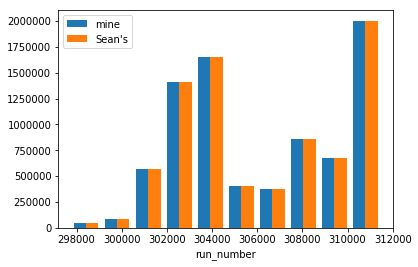

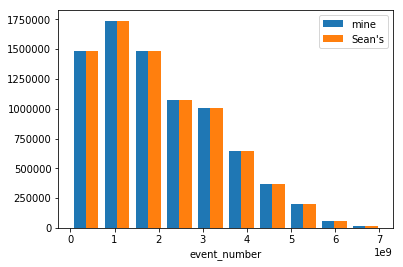

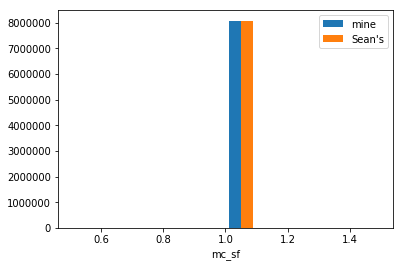

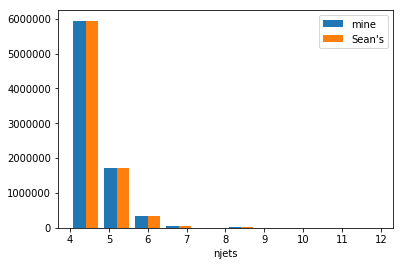

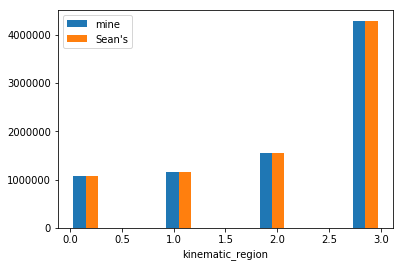

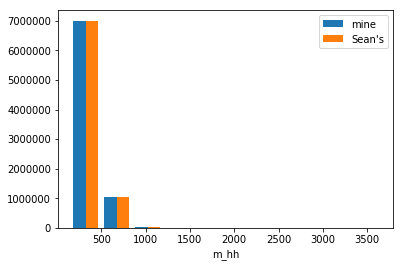

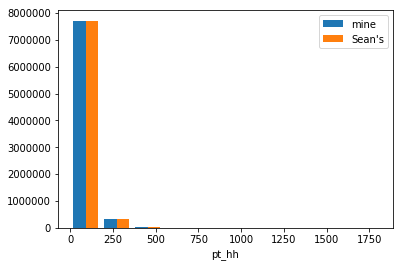

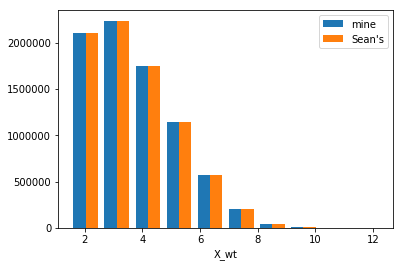

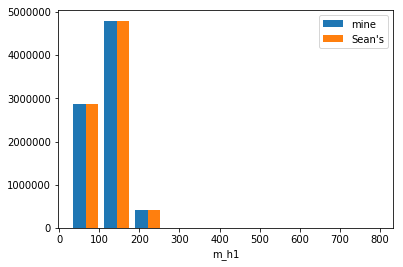

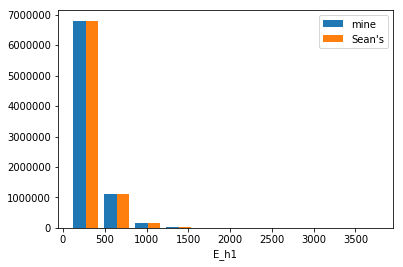

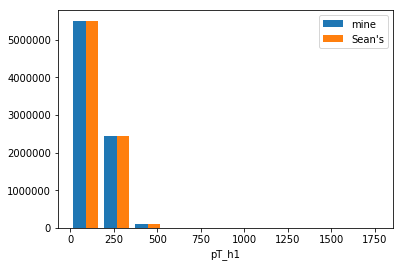

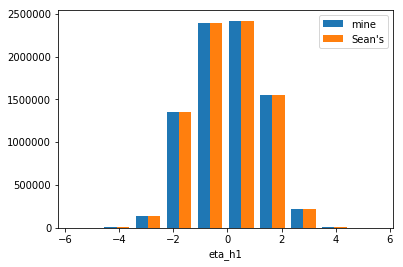

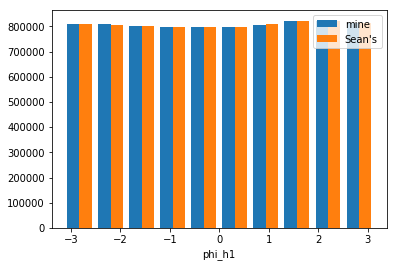

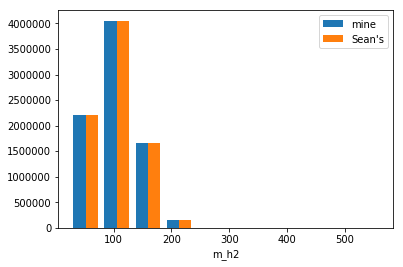

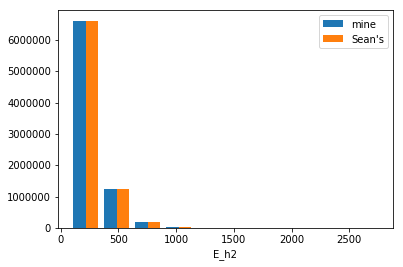

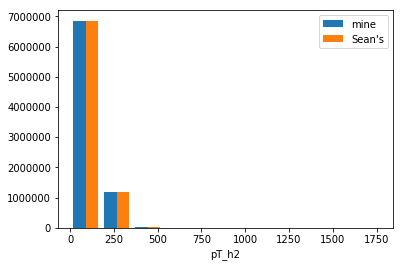

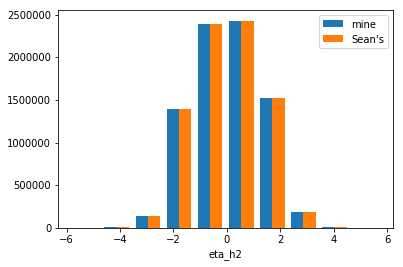

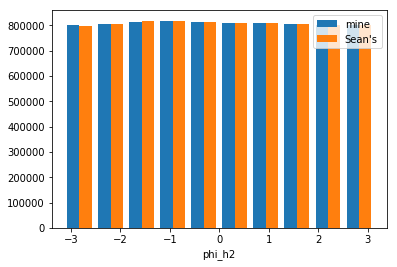

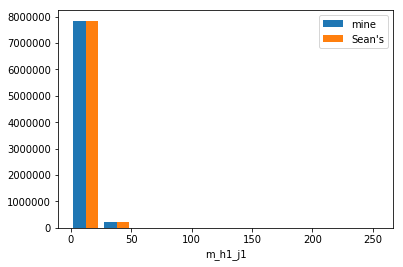

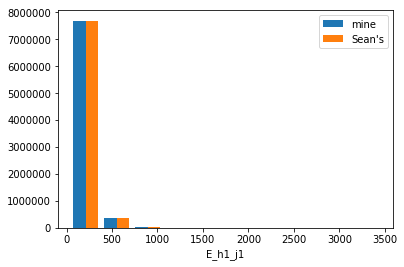

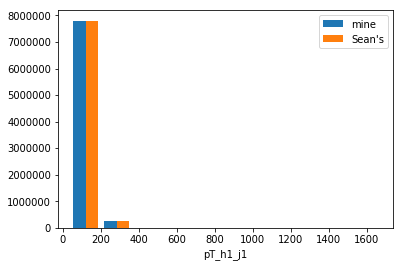

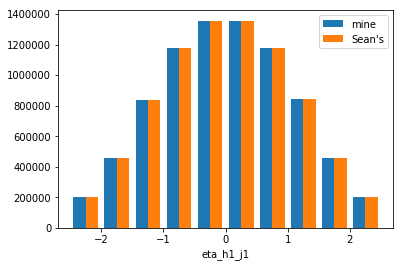

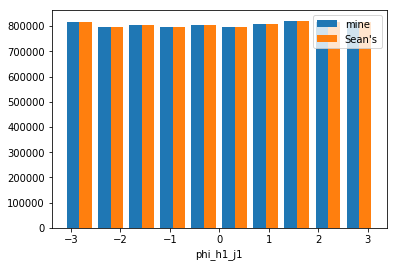

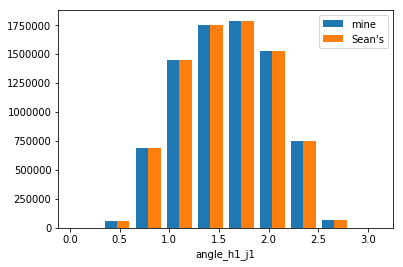

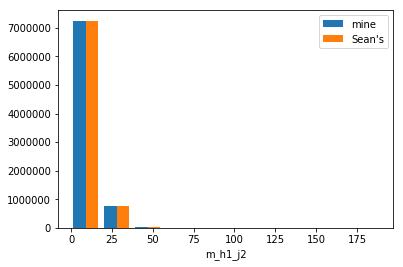

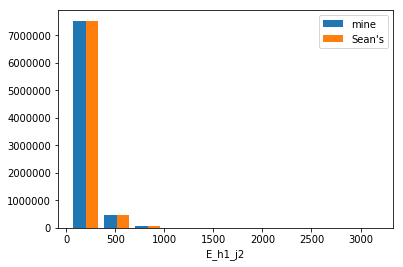

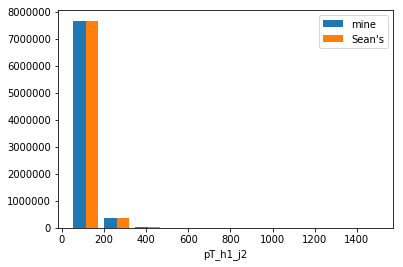

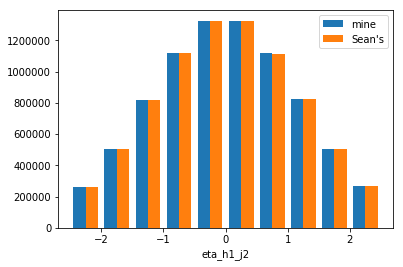

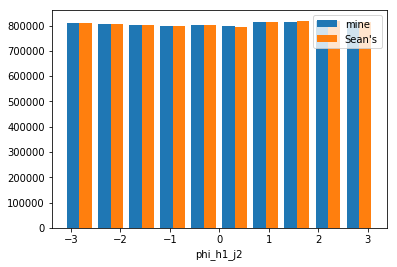

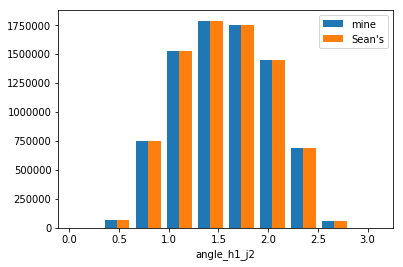

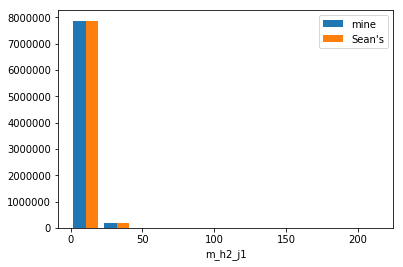

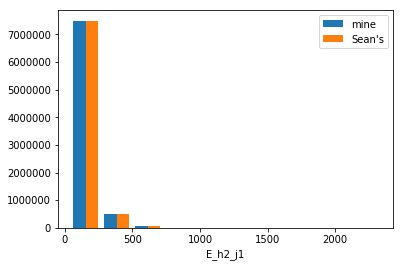

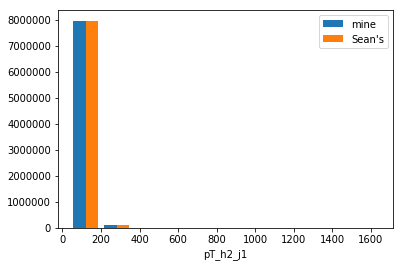

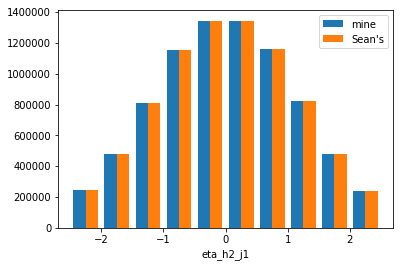

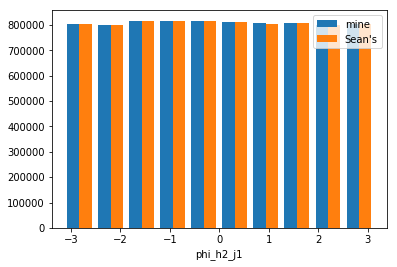

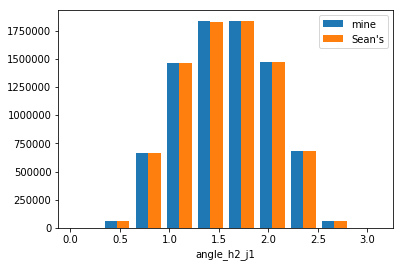

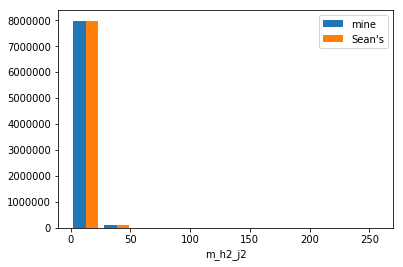

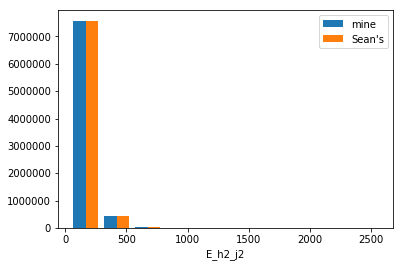

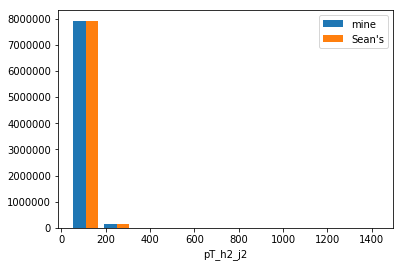

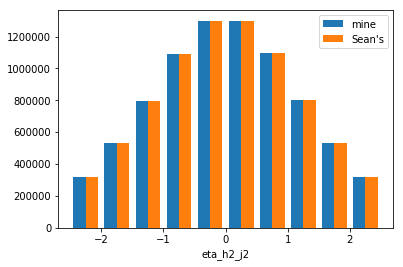

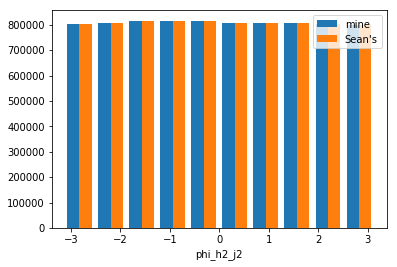

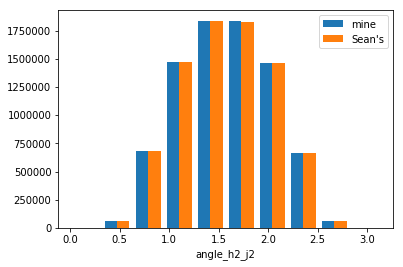

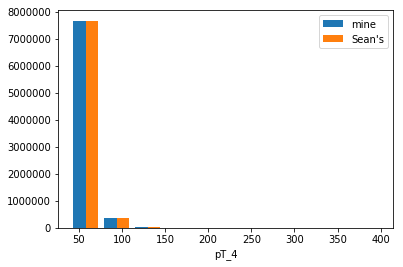

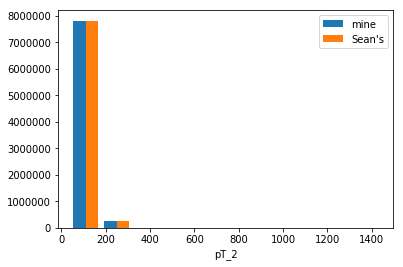

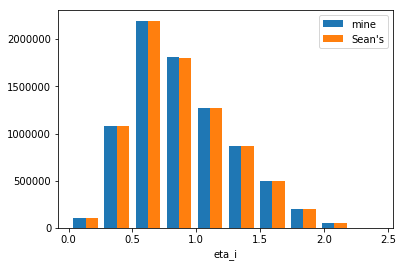

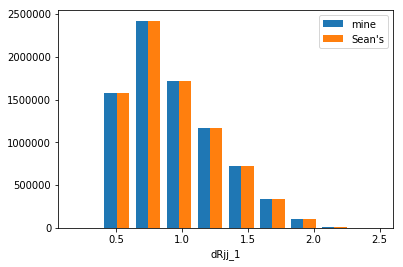

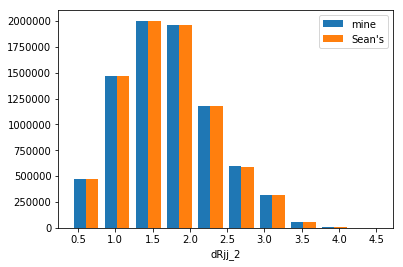

In [22]:
if sanityCheckPlots:
    for c in myData.columns:
        if (c in SeanData.columns) and ("tag" not in c):
            plt.hist([myData.loc[myData.ntag==2,c],SeanData.loc[SeanData.ntag==2,c]],
                     #histtype='step',
                     label=["mine","Sean's"],color=['C0','C1'])
            plt.xlabel(c)
            plt.legend()
            plt.show()
            #break

To avoid doing extra work, I think it's fine to use Sean's BDT.

(I could c.f. the one I trained myself?)

In [23]:
dataText = "$\mathbf{ATLAS}$ 2016 data\n"
#dataText += r"$\sqrt{s}$ = 13 TeV, $\mathcal{L}$ = 24.3 $fb^{-1}$"
dataText += "Baseline: MDR + $D_{hh}$"

Since the 2b $\rightarrow$ 4b extrapolation was derived *before* the $X_{wt}$ reweighting, I need to make sure that I'm retreiving this normalization as well.

In [24]:
# trainBDT=False

In [25]:
# minR1_BDT_afterXwt = "myBDTs/BDT_d24_16_rel21_vec_min_dRjj_h1_afterXwt{}.p"

# for tag,k in zip(['','CRderiv'],[2,1]):
#     getBDTWeights(minR1_data16,minR1_BDT_afterXwt.format(tag),
#                   trainBDT=trainBDT,kinematic_region=k)

**Compare in the SB**

In [26]:
makeBDTPlots=False

In [27]:
if makeBDTPlots:
    cf_1d_dists(SeanData,mask=(SeanData.kinematic_region==2),
                drawUnweighted=False, label="2b: SB derived weights", 
                w2b='BDT_d24_weight_16',extra_w='BDT_d24_weight_CRderiv_16',extra_label="2b: CR derived weights",
                extra_color='C6',
                dataText=dataText,nbi=25,chi2Only=False,
                figDir='figures/baseline/SeanBDT_CRderiv/',tag='_SB')

**Compare in the CR**

In [28]:
if makeBDTPlots:
    cf_1d_dists(SeanData,mask=(SeanData.kinematic_region==1),
                drawUnweighted=False, label="2b: SB derived weights", 
                w2b='BDT_d24_weight_16',extra_w='BDT_d24_weight_CRderiv_16',extra_label="2b: CR derived weights",
                extra_color='C6',title='control region',
                dataText=dataText,nbi=25,chi2Only=False,
                figDir='figures/baseline/SeanBDT_CRderiv/',tag='_CR')

**Note:** I thought it was super interesting that the njets agreement in the SB for the CR derived weights.

## Step 2: Get background variation histograms

Ok, so the previous paper derived the $m_{hh}$ varied histograms in two different $H_T$ regions, above and below 300 GeV.

I need to add this variable to the df.


In [29]:
jpT_cols = [f'pT_h{hci}_j{ji}' for hci in [1,2] for ji in [1,2]]
SeanData['HT'] = np.sum(SeanData[jpT_cols], axis=1)

Sanity check: What does $H_T$ look like?

In [30]:
sig_SR = (smnr.kinematic_region==0) & (smnr.ntag>=4)
bkg_SR = (SeanData.kinematic_region==0) & (SeanData.ntag==2)

edges = np.array([150, 250, 262, 275, 288, 302, 317, 332, 348, 365, 383, 402, 422, 443, 465, 488, 512, 
                  537, 563, 591, 620, 651, 683, 717, 752, 789, 828, 869, 912, 957,1004, 1054, 1106, 1161, 
                  1219, 1279, 1342, 1409, 1479, 1552, 1629, 1710, 1795, 1884, 1978, 2076])

#edges = np.linspace(100,1400,66)

In [31]:
def getNorm(df,k):
    '''
    Return the 2b -> 4b normalization in a specified kinematic region
    
    Inputs:
    - df: pandas df for data events
    - k: The kinematic region to calculate this normalization in
         * 2: SB
         * 1: CR
    
    '''
    return np.sum((df.kinematic_region==k) & (df.ntag>=4)) / np.sum((df.kinematic_region==k) & (df.ntag==2))

In [32]:
SeanData["w_2b"] = getNorm(SeanData,2) * SeanData["BDT_d24_weight_16"]
SeanData["w_2b_CR"] = getNorm(SeanData,2) * SeanData["BDT_d24_weight_CRderiv_16"]

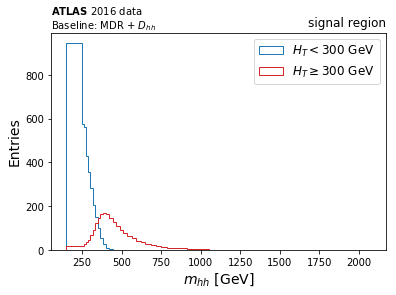

In [33]:
plt.hist(SeanData.loc[bkg_SR&(SeanData.HT < 300),"m_hh"],edges,color='C0',
         label='$H_T < 300$ GeV',histtype='step',
         weights=SeanData.loc[bkg_SR&(SeanData.HT < 300),"w_2b"])
plt.hist(SeanData.loc[bkg_SR&(SeanData.HT >= 300),"m_hh"],edges,color='C3',
         label='$H_T \geq 300$ GeV',histtype='step',
         weights=SeanData.loc[bkg_SR&(SeanData.HT >= 300),"w_2b"])

plt.title('signal region',loc='right')
plt.xlabel('$m_{hh}$ [GeV]',fontsize=14)
plt.ylabel('Entries',fontsize=14)

ax=plt.gca()
ax.text(0,1,dataText,ha='left',va='bottom',transform=ax.transAxes)

plt.legend(fontsize=12)

plt.savefig('figures/baseline/SeanBDT_CRderiv/HT_low_high.pdf',bbox_inches='tight')

plt.show()

Hmmm, why do I have this plateau at low $m_{hh}$??

Is it still there if I use Sean's bins?

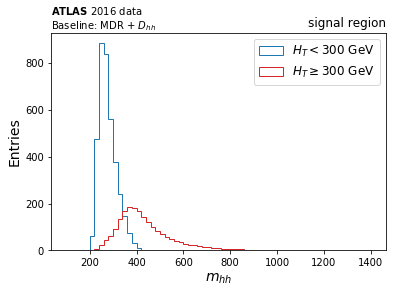

In [34]:
plt.hist(SeanData.loc[bkg_SR&(SeanData.HT < 300),"m_hh"],65,(100,1400),color='C0',
         label='$H_T < 300$ GeV',histtype='step',
         weights=SeanData.loc[bkg_SR&(SeanData.HT < 300),"w_2b"])
plt.hist(SeanData.loc[bkg_SR&(SeanData.HT >= 300),"m_hh"],65,(100,1400),color='C3',
         label='$H_T \geq 300$ GeV',histtype='step',
         weights=SeanData.loc[bkg_SR&(SeanData.HT >= 300),"w_2b"])

plt.title('signal region',loc='right')
plt.xlabel('$m_{hh}$',fontsize=14)
plt.ylabel('Entries',fontsize=14)

ax=plt.gca()
ax.text(0,1,dataText,ha='left',va='bottom',transform=ax.transAxes)

plt.legend(fontsize=12)

plt.savefig('figures/baseline/SeanBDT_CRderiv/HT_low_high_SeanBins.pdf',bbox_inches='tight')



plt.show()

Ok, now the plot looks the same as the one [Sean showed](https://indico.cern.ch/event/847722/contributions/3562856/attachments/1906345/3148432/2017-18_Limits_and_Shape_Var.pdf).

Getting the $H_T$ varying histograms...

/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide


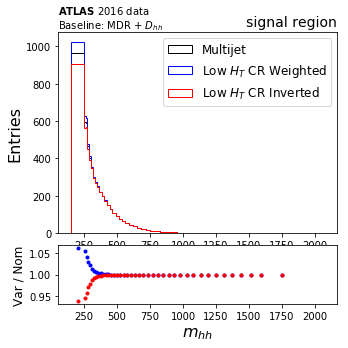

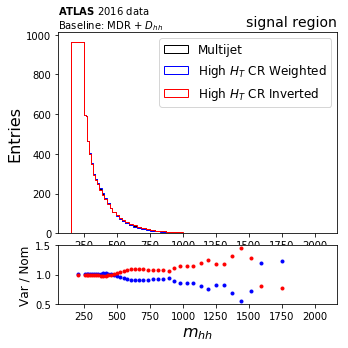

In [35]:
log=False

x = 0.5*(edges[:-1]+edges[1:])

var = {}

for HT,tag,ylim in zip([(SeanData.HT < 300),(SeanData.HT >= 300)],
                       ['Low','High'],[(.93,1.07),(0.5,1.5)]):

    fig = plt.figure(figsize=(5, 5))
    gs = gridspec.GridSpec(4,1)
    ax1 = fig.add_subplot(gs[:3,0])
    ax2 = fig.add_subplot(gs[3:,0],sharex=ax1)

    sb,_,_ = ax1.hist(SeanData.loc[bkg_SR,'m_hh'],
                      edges,color='k',histtype='step',
                      label='Multijet',log=log,
                      weights=SeanData.loc[bkg_SR,'w_2b'])

    cr,_,_ = ax1.hist(SeanData.loc[bkg_SR,'m_hh'],
                     edges,color='b',histtype='step',
                     label=f'{tag} $H_T$ CR Weighted',log=log,
                     weights=np.where(HT[bkg_SR],SeanData.loc[bkg_SR,'w_2b_CR'],SeanData.loc[bkg_SR,'w_2b']))


    inv,_,_ = ax1.hist(SeanData.loc[bkg_SR,'m_hh'],
                     edges,color='r',histtype='step',
                     label=f'{tag} $H_T$ CR Inverted',log=log,
                     weights=np.where(HT[bkg_SR],2*SeanData.loc[bkg_SR,'w_2b']-SeanData.loc[bkg_SR,'w_2b_CR'],
                                      SeanData.loc[bkg_SR,'w_2b']))

    ax2.plot(x,cr / sb,marker='.',color='blue',linewidth=0)
    ax2.plot(x,inv/sb,marker='.',color='r',linewidth=0)
  
    '''
    Append the histograms for the limits
    '''
    eps = 1e-15
    var[f'{tag}_HT'] = [list(cr+eps), list(inv+eps)]

    ax2.set_xlabel('$m_{hh}$',fontsize=16)

    ax1.set_ylabel('Entries',fontsize=16)
    ax1.text(0,1,dataText,ha='left',va='bottom',transform=ax1.transAxes)

    ax2.set_ylabel('Var / Nom',fontsize=12)

    ax1.legend(fontsize=12)#,bbox_to_anchor=(1,1.05))
    ax1.set_title('signal region', loc='right',fontsize=14)

    ax2.set_ylim(ylim)
    
    plt.savefig('figures/baseline/SeanBDT_CRderiv/m_hh_SR_{}_HT{}.pdf'.format(tag,"_log" if log else ""),
                bbox_inches='tight')

    plt.show()

## Step 3: Get the limit with the background systematic

Ok, so does this mean there are now 4 more histograms that get added for low and high $H_T$, CR weighted + inverted?

Nope, I think it's just the two low and high $H_T$ ones using the Correlated Shape Systematic for the low and high variations.


In [36]:
s,_ = np.histogram(smnr.loc[sig_SR,'m_hh'],edges,
                   weights=smnr.loc[sig_SR,'mc_sf'])

s = np.where(s>0,s,0)

**Could I plot the $m_{hh}$ histogram with the uncertainty indicated by a shaded histogram?**

Actually, I'm not 100% sure how I might do this clearly and honestly with the two different $H_T$ variations.


In [37]:
len(s)

45

In [38]:
mus = np.linspace(1,80, 80)
alpha=.05

mi = bkgSyst(list(s), list(sb), var)

# Get the scan over mu
hypo_tests = [pyhf.utils.hypotest(mu, mi.expected_data([0,0,0]), mi,
                                  [0.5,0,0], [(0,np.max(mus)),(-5,5),(-5,5)],
                                  return_expected_set=True,
                                  return_test_statistics=True,
                                  qtilde=True) for mu in mus]

cls_exp = [np.array([test[1][i] for test in hypo_tests]).flatten() for i in range(5)]

# Invert the interval
var_band = [np.interp(alpha, list(reversed(y_vals)), list(reversed(mus)))
            for y_vals in cls_exp]


/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3/lib/python3.7/site-packages/pyhf/tensor/numpy_backend.py:184: RuntimeWarning: divide by zero encountered in log
  return n * np.log(lam) - lam - gammaln(n + 1.0)
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3/lib/python3.7/site-packages/pyhf/tensor/numpy_backend.py:184: RuntimeWarning: invalid value encountered in multiply
  return n * np.log(lam) - lam - gammaln(n + 1.0)
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3/lib/python3.7/site-packages/pyhf/tensor/numpy_backend.py:184: RuntimeWarning: invalid value encountered in log
  return n * np.log(lam) - lam - gammaln(n + 1.0)


In [39]:
var_band

[13.193567270760052,
 17.75442009646648,
 24.735206797892534,
 34.60720897887133,
 46.699967909791646]

Ok, this is *great* because my sanity check passes, so I'm (in theory) equipped to test the variation of the fit on the low $m_{4j}$ region of the spectrum.

Plan: Let's do this fit for a few different $m_{4j}$ cuts


In [40]:
edges

array([ 150,  250,  262,  275,  288,  302,  317,  332,  348,  365,  383,
        402,  422,  443,  465,  488,  512,  537,  563,  591,  620,  651,
        683,  717,  752,  789,  828,  869,  912,  957, 1004, 1054, 1106,
       1161, 1219, 1279, 1342, 1409, 1479, 1552, 1629, 1710, 1795, 1884,
       1978, 2076])

In [41]:
cutoffs = np.array([1,5,8,11,12,13])

In [42]:
edges[cutoffs]

array([250, 302, 348, 402, 422, 443])

In [43]:
sys  = {k:[] for k in range(-2,3)}
stat = {k:[] for k in range(-2,3)}

ss = []
bs = []
zs = []

for cutoff in cutoffs:
    
    vi = {}
    for key in var.keys():
        vi[key] = [h[cutoff:] for h in var[key]]
    
    # Define the pyhf model
    mi = bkgSyst(list(s[cutoff:]), list(sb[cutoff:]), vi)
    
    # Do the fit
    # Get the scan over mu
    hypo_tests = [pyhf.utils.hypotest(mu, mi.expected_data([0,0,0]), mi,
                                      [0.5,0,0], [(0,np.max(mus)),(-5,5),(-5,5)],
                                      return_expected_set=True,
                                      return_test_statistics=True,
                                      qtilde=True) for mu in mus]

    cls_exp = [np.array([test[1][i] for test in hypo_tests]).flatten() for i in range(5)]

    # Invert the interval
    var_band = [np.interp(alpha, list(reversed(y_vals)), list(reversed(mus)))
                for y_vals in cls_exp]
    
    for k,v in zip(range(-2,3),var_band):
        sys[k].append(v)
     
    # Also append the significance for comparison
    si, bi = np.sum(s[cutoff:]), np.sum(sb[cutoff:])
    ss.append(si)
    bs.append(bi)
    zs.append( np.sqrt(np.sum((np.power(s[cutoff:],2) / sb[cutoff:])[sb[cutoff:]!=0])) )
    
    '''
    Stats only limit
    '''
    mj = simple(list(s[cutoff:]), list(sb[cutoff:]))
    
    # Do the fit
    # Get the scan over mu
    hypo_tests = [pyhf.utils.hypotest(mu, mj.expected_data([0]), mj,
                                      [0.5], [(0,np.max(mus))],
                                      return_expected_set=True,
                                      return_test_statistics=True,
                                      qtilde=True) for mu in mus]

    cls_exp = [np.array([test[1][i] for test in hypo_tests]).flatten() for i in range(5)]
    
    stat_band = [np.interp(alpha, list(reversed(y_vals)), list(reversed(mus)))
                 for y_vals in cls_exp]
    
    for k,v in zip(range(-2,3),stat_band):
        stat[k].append(v)


/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide


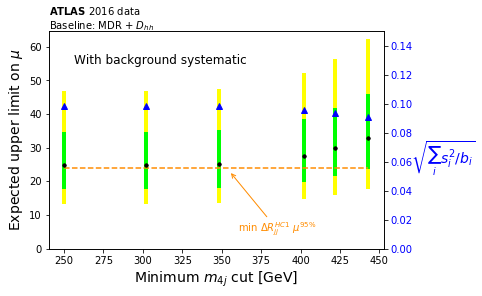

In [44]:
fig, ax1 = plt.subplots()

for i, c in zip([2,1],['yellow','lime'],):
    
    dy_up = np.array(sys[i]) - np.array(sys[0])
    dy_down =  np.array(sys[0]) - np.array(sys[-i])
    dy = np.vstack((dy_down,dy_up))
    
    ax1.errorbar(edges[cutoffs], sys[0], yerr=dy,
                 ecolor=c,elinewidth=4,linewidth=0, 
                 marker='.',color='k')
    
ax1.set_xlabel('Minimum $m_{4j}$ cut [GeV]',fontsize=14)
ax1.set_ylabel('Expected upper limit on $\mu$',fontsize=14)
 
_,ymax = ax1.get_ylim()
ax1.set_ylim(0,ymax)
     
# Annotate the plot
ax1.text(0,1,dataText,transform=ax1.transAxes)
    
ax1.text(0.075,.85,"With background systematic",
         transform=ax1.transAxes,fontsize=12)
 
plt.savefig('figures/baseline/SeanBDT_CRderiv/sysLim_m4j_cut.pdf',bbox_inches='tight')
    
# Overlay the significance
ax2 = ax1.twinx()
color='b'
ax2.set_ylabel(r'$\sqrt{\sum_i s_i^2 / b_i}$', color=color,
               fontsize=14,rotation=0, labelpad=30)
ax2.tick_params(axis='y', labelcolor=color)
ax2.plot(edges[cutoffs],zs,color=color,linewidth=0,marker="^")
ax2.set_ylim(0,.15)
  
plt.savefig('figures/baseline/SeanBDT_CRderiv/sysLim_m4j_cut_withSig.pdf',bbox_inches='tight')
    
# Draw a dashed line indicating where the systematics limit for
# min dRjj1 was
mindR1_mu = 23.9
ax1.plot([edges[cutoffs[0]],edges[cutoffs[-1]]],[mindR1_mu]*2,
         color='darkorange',linestyle='--')
  
ax1.annotate(r"min $\Delta R_{jj}^{HC1}$ $\mu^{95\%}$",
             (355,mindR1_mu-1),(360,5),color='darkorange',
             arrowprops=dict(arrowstyle="->",color='darkorange'))

plt.savefig('figures/baseline/SeanBDT_CRderiv/sysLim_m4j_cut_withMindR1.pdf',bbox_inches='tight')
    
plt.show()

Ok, this plot is a little complicated... maybe I should think about what messages I want to communicate here?

I'll just save 3 different versions of the plot, and let it feed in!


Ok, so I think the interesting comparison here is that we just want to also make sure that this effect is just coming from the the background, not to losing signal events.

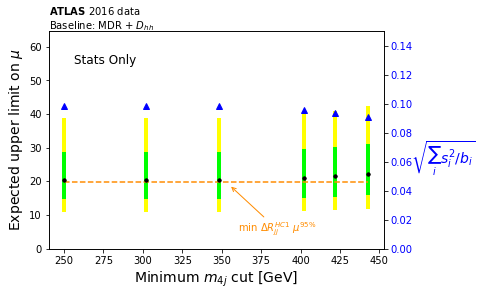

In [45]:
fig, ax1 = plt.subplots()

for i, c in zip([2,1],['yellow','lime'],):
    
    dy_up = np.array(stat[i]) - np.array(stat[0])
    dy_down =  np.array(stat[0]) - np.array(stat[-i])
    dy = np.vstack((dy_down,dy_up))
    
    ax1.errorbar(edges[cutoffs], stat[0], yerr=dy,
                 ecolor=c,elinewidth=4,linewidth=0, 
                 marker='.',color='k')
    
ax1.set_xlabel('Minimum $m_{4j}$ cut [GeV]',fontsize=14)
ax1.set_ylabel('Expected upper limit on $\mu$',fontsize=14)
 
ax1.set_ylim(0,ymax)
    
# Annotate the plot
ax1.text(0,1,dataText,transform=ax1.transAxes)
    
ax1.text(0.075,.85,"Stats Only",
         transform=ax1.transAxes,fontsize=12)
    
    
plt.savefig('figures/baseline/SeanBDT_CRderiv/statLim_m4j_cut.pdf',bbox_inches='tight')

    
# Overlay the significance
ax2 = ax1.twinx()
color='b'
ax2.set_ylabel(r'$\sqrt{\sum_i s_i^2 / b_i}$', color=color,
               fontsize=14,rotation=0, labelpad=30)
ax2.tick_params(axis='y', labelcolor=color)
ax2.plot(edges[cutoffs],zs,color=color,linewidth=0,marker="^")
ax2.set_ylim(0,.15)
  
plt.savefig('figures/baseline/SeanBDT_CRderiv/statLim_m4j_cut_withSig.pdf',bbox_inches='tight')

    
#Draw a dashed line indicating where the stats limit for min dRjj1 was
mindR1_mu = 19.8
ax1.plot([edges[cutoffs[0]],edges[cutoffs[-1]]],[mindR1_mu]*2,
         color='darkorange',linestyle='--')
    
ax1.annotate(r"min $\Delta R_{jj}^{HC1}$ $\mu^{95\%}$",
             (355,mindR1_mu-1),(360,5),color='darkorange',
             arrowprops=dict(arrowstyle="->",color='darkorange'))
    
plt.savefig('figures/baseline/SeanBDT_CRderiv/statLim_m4j_cut_withMindR1.pdf',bbox_inches='tight')
    
plt.show()

In [46]:
(stat[0][0]-mindR1_mu)/stat[0][0]*100

2.974824475309157

Ok, so it's only a 3% improvement if you compare to the *unscaled* baseline.

Ok, what (I think) this plot shows is that the stats only limit is following the same story as the sum of the bin significances in quadrature.

**How Rafael wanted me to show this information**

The significance on the plot really isn't helping, the message we want to tell is the comparison between the the systematic and the stats limit.


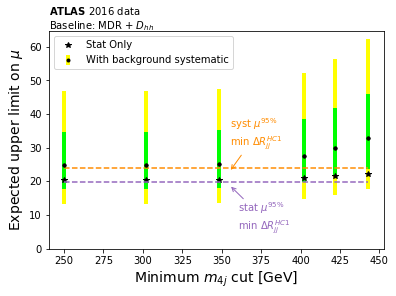

In [75]:
fig, ax1 = plt.subplots()

'''
Syst
'''
for i, c in zip([2,1],['yellow','lime'],):
    
    dy_up = np.array(sys[i]) - np.array(sys[0])
    dy_down =  np.array(sys[0]) - np.array(sys[-i])
    dy = np.vstack((dy_down,dy_up))
    
    ax1.errorbar(edges[cutoffs], sys[0], yerr=dy,
                 ecolor=c,elinewidth=4,linewidth=0, 
                 marker='.',color='k',label="With background systematic" if i==2 else None)
    
ax1.set_xlabel('Minimum $m_{4j}$ cut [GeV]',fontsize=14)
ax1.set_ylabel('Expected upper limit on $\mu$',fontsize=14)
 
_,ymax = ax1.get_ylim()
ax1.set_ylim(0,ymax)
     
# Annotate the plot
ax1.text(0,1,dataText,transform=ax1.transAxes)
     
'''
Stat lines
'''
dy_up = np.array(stat[i]) - np.array(stat[0])
dy_down =  np.array(stat[0]) - np.array(stat[-i])
dy = np.vstack((dy_down,dy_up))

plt.plot(edges[cutoffs], stat[0], linewidth=0, #alpha=0.2,
         marker='*',color='k',label='Stat Only')
    
    
ax1.set_xlabel('Minimum $m_{4j}$ cut [GeV]',fontsize=14)
ax1.set_ylabel('Expected upper limit on $\mu$',fontsize=14)
 
ax1.set_ylim(0,ymax)

plt.legend(loc='upper left')

    
plt.savefig('figures/baseline/SeanBDT_CRderiv/sys+statLim_m4j_cut.pdf',bbox_inches='tight')

'''
Draw a dashed line indicating where the stats limit for min dRjj1 was
'''    
#Stats
mindR1_mu = 19.8
ax1.plot([edges[cutoffs[0]],edges[cutoffs[-1]]],[mindR1_mu]*2,
         color='C4',linestyle='--')
    
ax1.annotate("stat $\mu^{95\%}$\nmin $\Delta R_{jj}^{HC1}$",
             (355,mindR1_mu-1),(360,5),color='C4',
             arrowprops=dict(arrowstyle="->",color='C4'))
  
# Sys

mindR1_mu = 23.9
ax1.plot([edges[cutoffs[0]],edges[cutoffs[-1]]],[mindR1_mu]*2,
         color='darkorange',linestyle='--')
  
ax1.annotate("syst $\mu^{95\%}$\nmin $\Delta R_{jj}^{HC1}$",
             (355,mindR1_mu-1),(355,30),color='darkorange',
             arrowprops=dict(arrowstyle="->",color='darkorange'))


    
plt.savefig('figures/baseline/SeanBDT_CRderiv/sys+statLim_m4j_cut_withMindR1.pdf',bbox_inches='tight')
    
plt.show()

In [70]:
stat[0]/stat[0][0]

array([1.        , 1.00012787, 1.00274717, 1.02776791, 1.05228084,
       1.08498936])

In [71]:
sys[0]/sys[0][0]

array([1.        , 1.00096792, 1.01401463, 1.11424817, 1.20563823,
       1.33063839])

**Massplane plot cutting at 350 GeV**

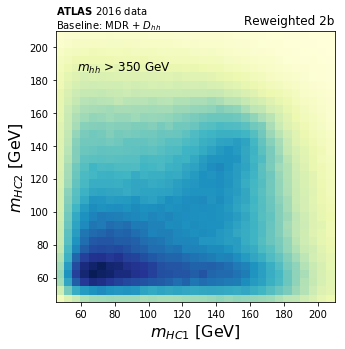

In [73]:
fig, ax = plt.subplots(1,1,figsize=(5,5))

mBins = 33
mhRanges=[(45,210)]*2

loc=(52,195)

bkg_mask = (SeanData.ntag == 2)& (SeanData.m_hh > 350) 
plt.hist2d(SeanData.loc[bkg_mask,"m_h1"],SeanData.loc[bkg_mask,"m_h2"],
           mBins,mhRanges,cmap="YlGnBu",weights=SeanData.loc[bkg_mask,"w_2b"])

ax = plt.gca()
plt.text(0,1,dataText,transform=ax.transAxes)
plt.text(0.075,.85,"$m_{hh}$ > 350 GeV",
         transform=ax.transAxes,fontsize=12)

plt.xlabel('$m_{HC1}$ [GeV]',fontsize=16)
plt.ylabel('$m_{HC2}$ [GeV]',fontsize=16)

plt.title('Reweighted 2b',loc='right')

plt.savefig('figures/baseline/massplane2b_mhh>350GeV.pdf',bbox_inches='tight')

plt.show()

Let's do the plot of varying the $X_{hh}$ cut that Michael asked me to look into.

In [48]:
for df in [smnr,SeanData]:
    
    df['Xhh'] = 10*np.sqrt(np.power((df.m_h1-120)/df.m_h1,2)+np.power((df.m_h2-110)/df.m_h2,2))
    

In [49]:
cuts = np.linspace(.5,2,16)
zis = []

for cut in cuts:
    
    mask_4b = (smnr.ntag >= 4) & (smnr.Xhh < cut)
    mask_2b = (SeanData.ntag == 2) & (SeanData.Xhh < cut)
    
    si,_ = np.histogram(smnr.loc[mask_4b,'m_hh'],  edges,weights=smnr.loc[mask_4b,'mc_sf'])
    bi,_ = np.histogram(SeanData.loc[mask_2b,'m_hh'],edges,weights=SeanData.loc[mask_2b,'w_2b'])
 
    zis.append( np.sqrt(np.sum((np.power(si,2) / bi)[bi>0])))
    

/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


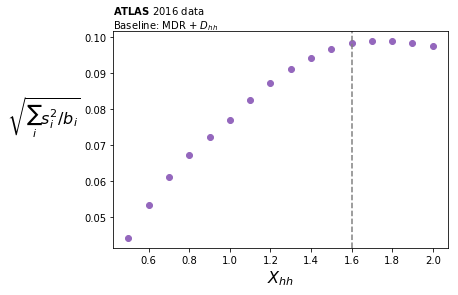

In [50]:
plt.plot(cuts,zis,marker='o',color='C4',linewidth=0)

ax = plt.gca()
plt.text(0,1,dataText,transform=ax.transAxes)
plt.xlabel('$X_{hh}$',fontsize=16)
plt.ylabel(r'$\sqrt{\sum_i s_i^2 / b_i}$',fontsize=16,
           rotation=0,labelpad=40)

ylim = plt.ylim()
plt.plot([1.6]*2,ylim,'grey',linestyle='--')
plt.ylim(ylim)

plt.savefig('figures/baseline/SeanBDT_CRderiv/significance_Xhh.pdf',bbox_inches='tight')

plt.show()

In [51]:
zs[-5]

0.09833811829913253

Ok, this is all looking *consistent*.